In [77]:
import pandas as pd
import numpy as np
from pandas import read_excel
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import random
import itertools
import pickle
plt.style.use('fivethirtyeight') # For plots
import os
#Author: Vatsala

In [78]:
#import fbprophet
#fbprophet.__version__

In [79]:
#import utils

In [80]:
plot_file_path ="../prophetForecastPlots/Plot"
plot_data_path ="../plotData/"

In [81]:
#### Specify Plot ID

In [82]:
plotId = "1"

In [83]:
#### Create directory for storing facebook prophet forecasts

In [84]:
# define the name of the directory to be created for the png outputs

path_image = plot_file_path+str(plotId)

try:
    if not os.path.exists(path_image):     
         os.mkdir(path_image)
except OSError:
    print ("Creation of the directory %s failed" % path_image)
else:
    print ("Successfully created the directory %s " % path_image)

Successfully created the directory ../prophetForecastPlots/Plot1 


In [85]:
#****** Running Forecast for Plot 1 *******  Note: Data has been QC-ed

#read Plot 1 data
data = read_excel('../plotData/Plot'+plotId+'/CH4_InterResamp3hour.xlsx', sheet_name='Sheet1')    #index_col=13, parse_dates=[13]

In [86]:
#print(data.head(10))
data.dtypes

DateTime    datetime64[ns]
Flux               float64
dtype: object

### Read the met data (Air Parameters) - the regressors to be added
Soil heat, air temperature, relative humidity, atmospheric pressure, total precipitation

In [87]:
metData_AirParams = read_excel('../plotData/MetData_AirParams.xlsx', sheet_name='Sheet1') 


metData_AirParams['ds'] = metData_AirParams['TIMESTAMP_1_rounded']

metData_AirParams.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
metData_AirParams.drop('TIMESTAMP_1_rounded', axis=1, inplace=True)
metData_AirParams

,G_1_1_1,G_2_1_1,Ta_1_1_1,RH_1_1_1,Pa_1_1_1,P_1_1_1
ds,,,,,,
2019-03-26 17:30:00,1.185082,2.853651,11.850,54.435,101.8,0.0
2019-03-27 08:30:00,3.637683,5.828328,7.262,78.595,102.1,0.0
2019-03-27 09:00:00,10.508773,12.427950,7.648,77.565,102.1,0.0
2019-03-27 09:30:00,20.978545,23.094235,8.465,75.635,102.1,0.0
2019-03-27 10:00:00,33.931725,36.153975,9.505,71.990,102.1,0.0
...,...,...,...,...,...,...
2019-06-29 18:30:00,40.378545,18.857910,28.225,51.725,99.6,0.0
2019-06-29 19:00:00,27.381235,12.488385,26.360,57.805,99.6,0.0
2019-06-29 19:30:00,19.718745,9.545013,25.520,62.120,99.6,0.0


### Round the met data to the nearest hour to get matching timestamps with gas flux data

In [88]:
plot_dataframe = metData_AirParams.copy()

plot_dataframe['ds'] = metData_AirParams.index
#plot_dataframe['Flux']      = data['Flux']

#round the timestamp value to nearest half hour
plot_dataframe['ds'] = plot_dataframe['ds'].dt.round('1H')

#Drop the column Timestamp - the rounded Timestamp value will be used for plotting
#plot_dataframe.reset_('ds', axis=1, inplace=True)

#Create new index
plot_dataframe.reset_index(drop=True, inplace=True)
plot_dataframe.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)

#plot_dataframe

### Resampling every 3 hour

In [89]:
resample        = plot_dataframe.resample('3H') 
daily_mean_flux = resample.mean()

daily_mean_flux.to_csv('ch4_resample_3hour')
#print(daily_mean_flux)

In [90]:
metData_AirParams = daily_mean_flux

### Merge the metdata together with the (gas flux) plot data

In [91]:
#metData_AirParams.to_csv('metdata-ariparams1.csv')
#metData_AirParams

In [92]:
#temp = metData_AirParams.interpolate(method='linear')

In [93]:
#temp.to_csv('metdata-ariparams1.csv')
#temp

In [94]:
df1 = data.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
df1.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
df1.drop('index', axis=1, inplace=True)
#df1.to_csv('ch4_3hrregre11.csv')
#df1

In [95]:
#df1.info()

In [96]:
merged_df1 = df1.merge(metData_AirParams, left_index=True, right_index=True, how='inner')

#merged_df1

#### There are missing values in the dataset - which can be replaced using Interpolation
(provided there is not a large gap between the timestamps)

### Interpolation to replace missing values

In [97]:
merged_df1 = merged_df1.interpolate(method='linear')
#merged_df1

### Add Regressors to the model

#### Split the merged dataset into training and test set on Resampled Dataset

In [98]:
#Train Test - split data
split_date = '31-May-2019'   #'30-April-2019'

#dataf = daily_mean_flux

mergeddf_train_gas = merged_df1.loc[merged_df1.index <= split_date].copy()
mergeddf_test_gas  = merged_df1.loc[merged_df1.index > split_date].copy()

mergeddf_train_gas.reset_index(inplace=True)
mergeddf_test_gas.reset_index(inplace=True)
#print(mergeddf_test_CO2dry.head(10))
#print(mergeddf_train_CO2dry.head(10))

In [99]:
#mergeddf_train_gas

In [100]:
pro_regressor = Prophet()  #add tuning parameters later
pro_regressor.add_regressor('G_1_1_1')
pro_regressor.add_regressor('G_2_1_1')
pro_regressor.add_regressor('Ta_1_1_1')
pro_regressor.add_regressor('RH_1_1_1')
pro_regressor.add_regressor('Pa_1_1_1')
pro_regressor.add_regressor('P_1_1_1')

#Fitting the data
pro_regressor.fit(mergeddf_train_gas)

#future_data = pro_regressor.make_future_dataframe(periods=14, freq='D')

#forecast the data for Test  data
forecast_data1 = pro_regressor.predict(mergeddf_test_gas)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


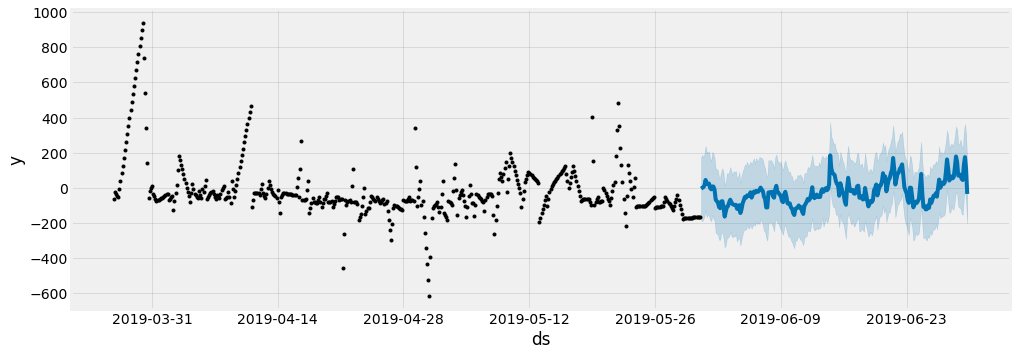

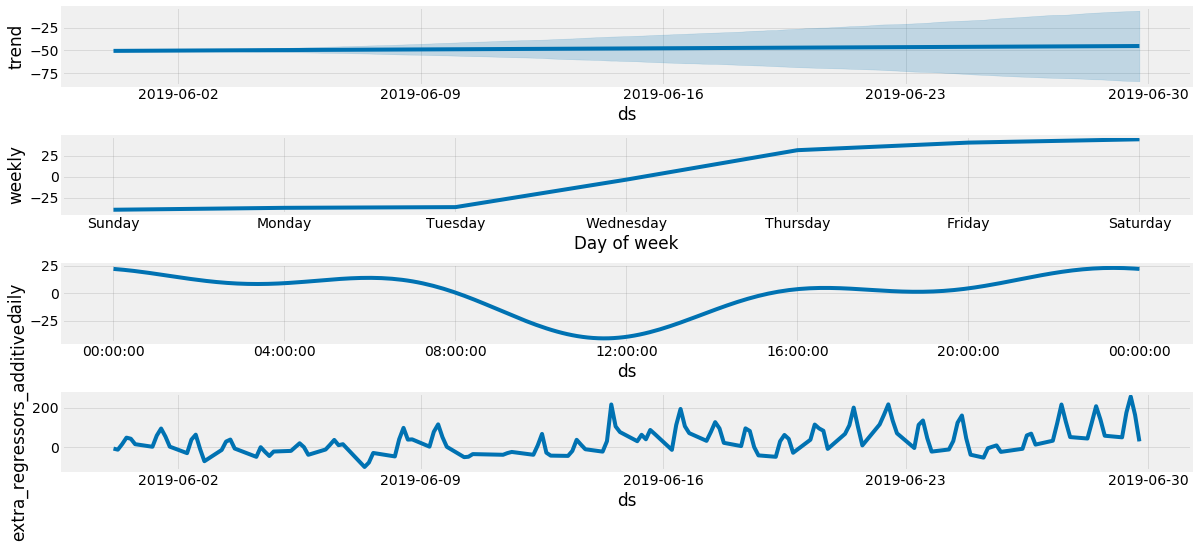

In [101]:
fig21 = pro_regressor.plot(forecast_data1);
fig22 = pro_regressor.plot_components(forecast_data1)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

### Compare the gas flux in test set and in forecasted set

In [102]:
pd.plotting.register_matplotlib_converters()

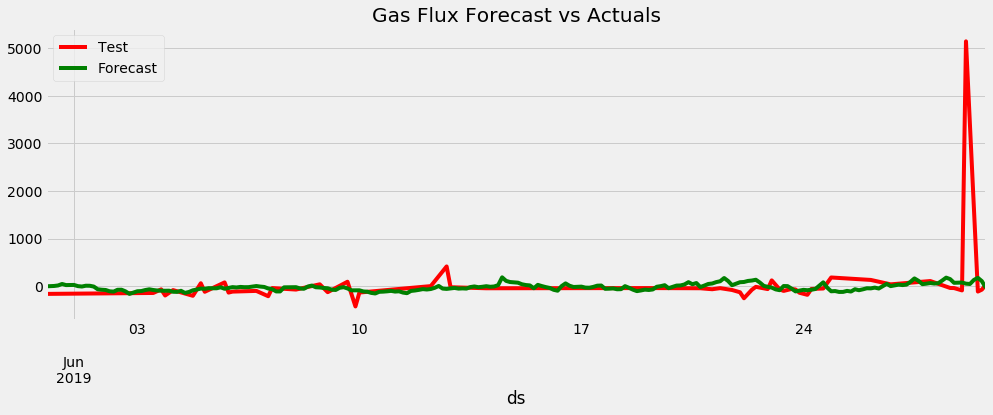

In [103]:
df1=mergeddf_test_gas

f, ax = plt.subplots(figsize=(18,5))
f.set_figheight(5)
f.set_figwidth(15)

df1.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
forecast_data1.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
#ax.set_xticklabels(df1.index, rotation=30, ha='right', color = 'green')

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Measure the performance of the model

In [104]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [105]:
mape = mean_absolute_percentage_error(df1['y'],forecast_data1['yhat'])
print("MAPE",round(mape,4))

MAPE 257.6459


In [106]:
# Try a different combination of parameters

In [131]:
pro_regressor1 = Prophet(
    changepoint_prior_scale= 0.01,
    changepoint_range= 0.8,
    #n_changepoints= 125,
    seasonality_prior_scale= 0.1,
    seasonality_mode = 'multiplicative',
    growth = 'linear' )

pro_regressor1.add_regressor('G_1_1_1')
pro_regressor1.add_regressor('G_2_1_1')
pro_regressor1.add_regressor('Ta_1_1_1')
pro_regressor1.add_regressor('RH_1_1_1')
pro_regressor1.add_regressor('Pa_1_1_1')
pro_regressor1.add_regressor('P_1_1_1')

#Fitting the data
pro_regressor1.fit(mergeddf_train_gas)

#future_data = pro_regressor.make_future_dataframe(periods=14, freq='D')

#forecast the data for Test  data
forecast_data2 = pro_regressor1.predict(mergeddf_test_gas)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [108]:
#fig21 = pro_regressor1.plot(forecast_data2);
#fig22 = pro_regressor1.plot_components(forecast_data2)

#fig21.set_figheight(5)
#fig21.set_figwidth(15)

#fig22.set_figheight(7)
#fig22.set_figwidth(19)

In [109]:
### Compare the gas flux in test set and in forecasted set

In [110]:
#df1=mergeddf_test_gas

#f, ax = plt.subplots(figsize=(14,5))
#f.set_figheight(5)
#f.set_figwidth(15)

#df1.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
#forecast_data2.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

#plt.title('Gas Flux Forecast vs Actuals')
#plt.show() 

### Read the met data (Radiation Parameters) - the regressors to be added

In [132]:
metData_RadiationParams = read_excel('../plotData/MetData_Radiation_Filtered.xlsx', sheet_name='Sheet1') 

metData_RadiationParams['ds'] = metData_RadiationParams['TIMESTAMP_1_rounded']

metData_RadiationParams.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
metData_RadiationParams.drop('TIMESTAMP_1_rounded', axis=1, inplace=True)
#metData_RadiationParams

### Round the met data to the nearest hour to get matching timestamps with gas flux data

In [133]:
plot_dataframe1 = metData_RadiationParams.copy()

plot_dataframe1['ds'] = metData_RadiationParams.index

#round the timestamp value to nearest half hour
plot_dataframe1['ds'] = plot_dataframe1['ds'].dt.round('1H')

#Create new index
plot_dataframe1.reset_index(drop=True, inplace=True)
plot_dataframe1.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)

#plot_dataframe1

### Resampling every 3 hour

In [134]:
resample1        = plot_dataframe1.resample('3H') 
daily_mean_flux1 = resample1.mean()

#print(daily_mean_flux1)

### Merge the Radiation metdata together with the (gas flux) plot data

In [135]:
metData_RadiationParams = daily_mean_flux1

In [136]:
metData_RadiationParams.to_csv('metdata-airparams1.csv')
#metData_RadiationParams

In [137]:
#tempR = metData_RadiationParams.interpolate(method='linear')

In [138]:
#tempR

In [139]:
dfR = data.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
dfR.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
dfR.drop('index', axis=1, inplace=True)
#dfR

In [140]:
merged_df_R = dfR.merge(metData_RadiationParams, left_index=True, right_index=True, how='inner')

#merged_df_R

### Add Regressors to the model

In [141]:
#merged_df_R

### Interpolate to replace missing values

In [142]:
merged_df_R = merged_df_R.interpolate(method='linear')
merged_df_R

,y,PPFD_1_1_1,SWin_1_1_1,SWout_1_1_1,LWin_1_1_1,LWout_1_1_1,Rnet_1_1_1
ds,,,,,,,
2019-03-26 18:00:00,-61.782600,277.500000,146.150000,33.140000,267.100000,366.250000,13.860000
2019-03-26 21:00:00,-25.552200,238.631250,123.532813,27.580875,284.225000,362.262500,17.914437
2019-03-27 00:00:00,-35.076767,199.762500,100.915625,22.021750,301.350000,358.275000,21.968875
2019-03-27 03:00:00,-44.601333,160.893750,78.298438,16.462625,318.475000,354.287500,26.023312
2019-03-27 06:00:00,-54.125900,122.025000,55.681250,10.903500,335.600000,350.300000,30.077750
...,...,...,...,...,...,...,...
2019-06-29 06:00:00,3393.950867,732.928571,325.978571,82.479286,332.250000,417.171429,158.577857
2019-06-29 09:00:00,1639.499833,1708.900000,781.660000,161.890000,340.610000,475.520000,484.860000
2019-06-29 12:00:00,-114.951200,1957.500000,902.214286,167.771429,363.421429,507.092857,590.771429


#### Split the merged dataset into training and test set on Resampled Dataset

In [143]:
#Train Test - split data
split_date = '31-May-2019'   #'30-April-2019'

#dataf = daily_mean_flux

mergeddf_train_gasRa = merged_df_R.loc[merged_df_R.index <= split_date].copy()
mergeddf_test_gasRa  = merged_df_R.loc[merged_df_R.index > split_date].copy()

mergeddf_train_gasRa.reset_index(inplace=True)
mergeddf_test_gasRa.reset_index(inplace=True)

#mergeddf_train_gasRa.dropna(inplace=True)
#mergeddf_test_gasRa.dropna(inplace=True)

In [144]:
#mergeddf_train_gasRa

In [145]:
merged_df_R.to_excel('ch4_radiationparams_3h.xlsx')

### Create Prophet model

In [146]:
pro_regressorR = Prophet()  #add tuning parameters later
pro_regressorR.add_regressor('PPFD_1_1_1')
pro_regressorR.add_regressor('SWin_1_1_1')
pro_regressorR.add_regressor('SWout_1_1_1')
pro_regressorR.add_regressor('LWin_1_1_1')
pro_regressorR.add_regressor('LWout_1_1_1')
pro_regressorR.add_regressor('Rnet_1_1_1')

#Fitting the data
pro_regressorR.fit(mergeddf_train_gasRa)

#future_data = pro_regressor.make_future_dataframe(periods=14, freq='D')

#forecast the data for Test  data
forecast_dataR1 = pro_regressorR.predict(mergeddf_test_gasRa)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


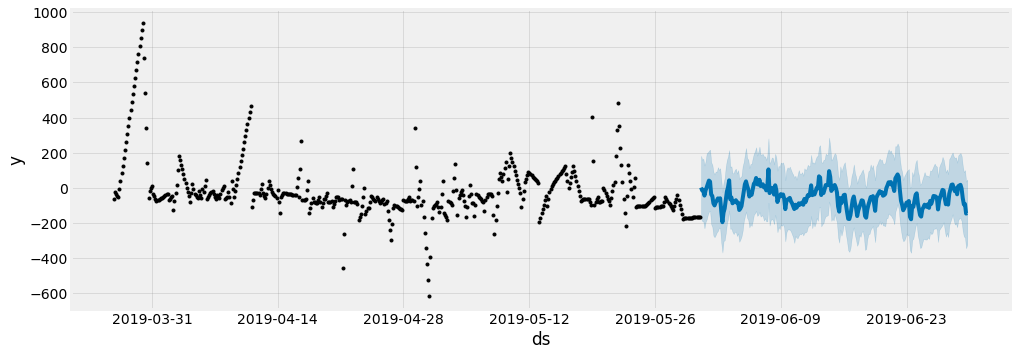

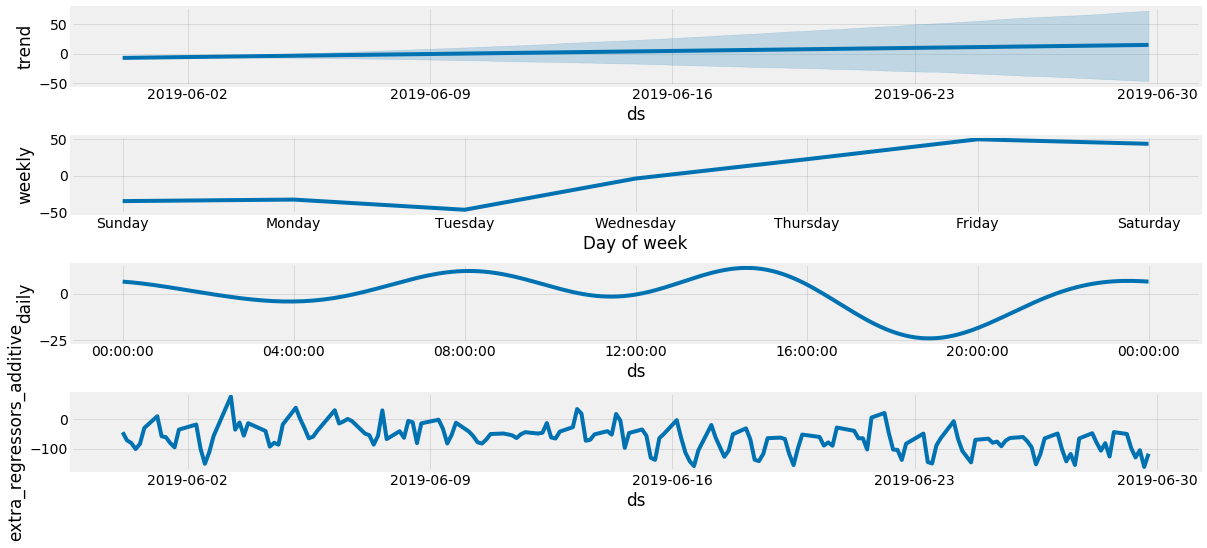

In [147]:
fig21 = pro_regressorR.plot(forecast_dataR1);
fig22 = pro_regressorR.plot_components(forecast_dataR1)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

### Measure the performance of the model

In [148]:
mape = mean_absolute_percentage_error(mergeddf_test_gasRa['y'],forecast_dataR1['yhat'])
print("MAPE",round(mape,4))

MAPE 203.4228


In [149]:
### Try with a new model configuration

### Compare the gas flux in test set and in forecasted set

In [150]:
pd.plotting.register_matplotlib_converters()

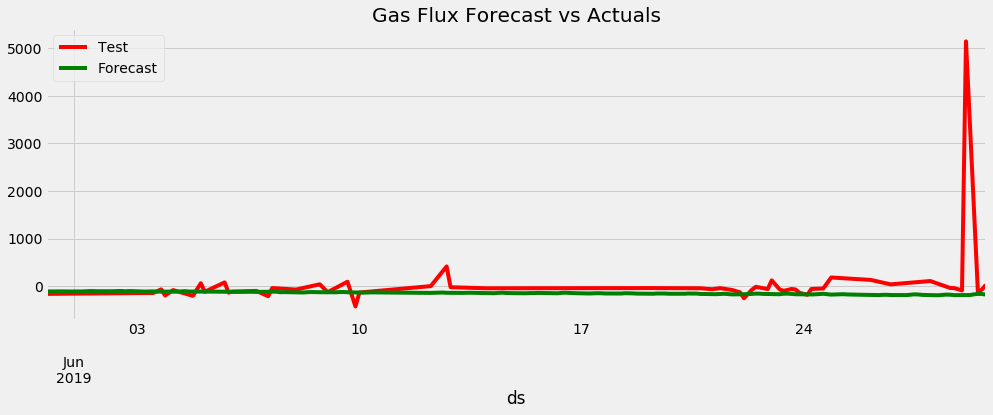

In [151]:
df2=mergeddf_test_gasRa

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df2.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
forecast_data2.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Read the met data (Soil Parameters STP) - the regressors to be added

In [152]:
metData_SoilSTPParams = read_excel('../plotData/MetData_SoilParams_STP_Filtered.xlsx', sheet_name='Sheet1') 

metData_SoilSTPParams['ds'] = metData_SoilSTPParams['TIMESTAMP_1_rounded']

metData_SoilSTPParams.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
metData_SoilSTPParams.drop('TIMESTAMP_1_rounded', axis=1, inplace=True)
#metData_SoilSTPParams

### Round the met data to the nearest hour to get matching timestamps with gas flux data

In [153]:
plot_dataframe2 = metData_SoilSTPParams.copy()

plot_dataframe2['ds'] = metData_SoilSTPParams.index

#round the timestamp value to nearest half hour
plot_dataframe2['ds'] = plot_dataframe2['ds'].dt.round('1H')

#Create new index
plot_dataframe2.reset_index(drop=True, inplace=True)
plot_dataframe2.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)

#plot_dataframe2

### Resampling every 3 hour

In [154]:
resample2        = plot_dataframe2.resample('3H') 
daily_mean_flux2 = resample2.mean()

#print(daily_mean_flux2)

### Merge the metdata together with the (gas flux) plot data

In [155]:
metData_SoilSTPParams = daily_mean_flux2

metData_SoilSTPParams.to_csv('metdata-soilSTPparams.csv')
#metData_SoilSTPParams

In [156]:
#tempSTP = metData_SoilSTPParams.interpolate(method='linear')

In [157]:
#tempSTP

In [158]:
dfSTP = data.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
dfSTP.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
dfSTP.drop('index', axis=1, inplace=True)
#dfSTP

### Add Regressors to the model

In [159]:
merged_df_STP = dfSTP.merge(metData_SoilSTPParams, left_index=True, right_index=True, how='inner')

#merged_df_STP

### Interpolate to replace missing values

In [160]:
merged_df_STP = merged_df_STP.interpolate(method='linear')
merged_df_STP

,y,STP_TSoil_2_1_1_1,STP_TSoil5_1_1_1,STP_TSoil10_1_1_1,STP_TSoil20_1_1_1,STP_TSoil50_1_1_1
ds,,,,,,
2019-03-26 18:00:00,-61.782600,8.512857,9.307143,10.806429,11.038571,10.717143
2019-03-26 21:00:00,-25.552200,8.501000,9.377000,9.706000,9.328000,8.757000
2019-03-27 00:00:00,-35.076767,8.519286,9.165000,8.733571,8.028286,7.232571
2019-03-27 03:00:00,-44.601333,8.543000,8.802000,7.882500,7.201100,6.684700
2019-03-27 06:00:00,-54.125900,8.559286,8.473571,7.616929,7.188214,6.954714
...,...,...,...,...,...,...
2019-06-29 12:00:00,-114.951200,14.473571,16.321429,19.018571,21.013571,22.800000
2019-06-29 15:00:00,-74.633900,14.479000,17.048000,20.168000,21.718000,22.736000
2019-06-29 18:00:00,26.288600,14.507143,17.586429,20.122143,20.993571,21.405000


#### Split the merged dataset into training and test set on Resampled Dataset

In [161]:
#Train Test - split data
split_date = '31-May-2019'   #'30-April-2019'

#dataf = daily_mean_flux

mergeddf_train_gasSTP = merged_df_STP.loc[merged_df_STP.index <= split_date].copy()
mergeddf_test_gasSTP  = merged_df_STP.loc[merged_df_STP.index > split_date].copy()

mergeddf_train_gasSTP.reset_index(inplace=True)
mergeddf_test_gasSTP.reset_index(inplace=True)

In [162]:
#mergeddf_train_gasSTP.dropna(inplace=True)
#mergeddf_test_gasSTP.dropna(inplace=True)

In [163]:
#mergeddf_train_gasSTP

### Create Prophet model

In [164]:
pro_regressorSTP = Prophet()  #add tuning parameters later
pro_regressorSTP.add_regressor('STP_TSoil_2_1_1_1')
pro_regressorSTP.add_regressor('STP_TSoil5_1_1_1')
pro_regressorSTP.add_regressor('STP_TSoil10_1_1_1')
pro_regressorSTP.add_regressor('STP_TSoil20_1_1_1')
pro_regressorSTP.add_regressor('STP_TSoil50_1_1_1')

#Fitting the data
pro_regressorSTP.fit(mergeddf_train_gasSTP)

#future_data = pro_regressor.make_future_dataframe(periods=14, freq='D')

#forecast the data for Test  data
forecast_dataSTP = pro_regressorSTP.predict(mergeddf_test_gasSTP)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


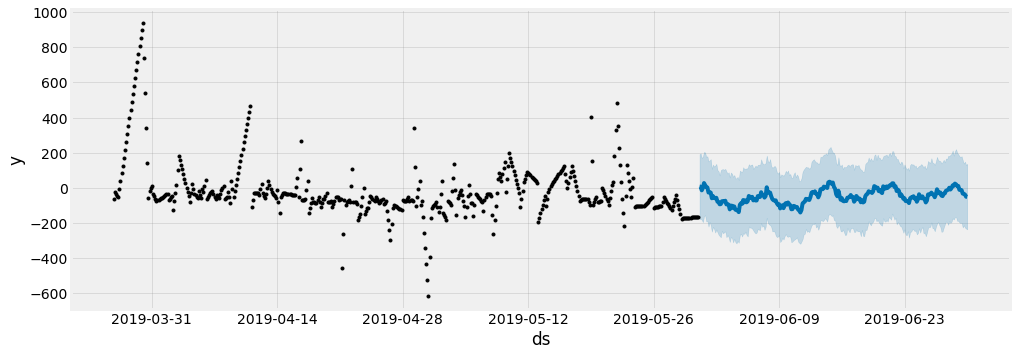

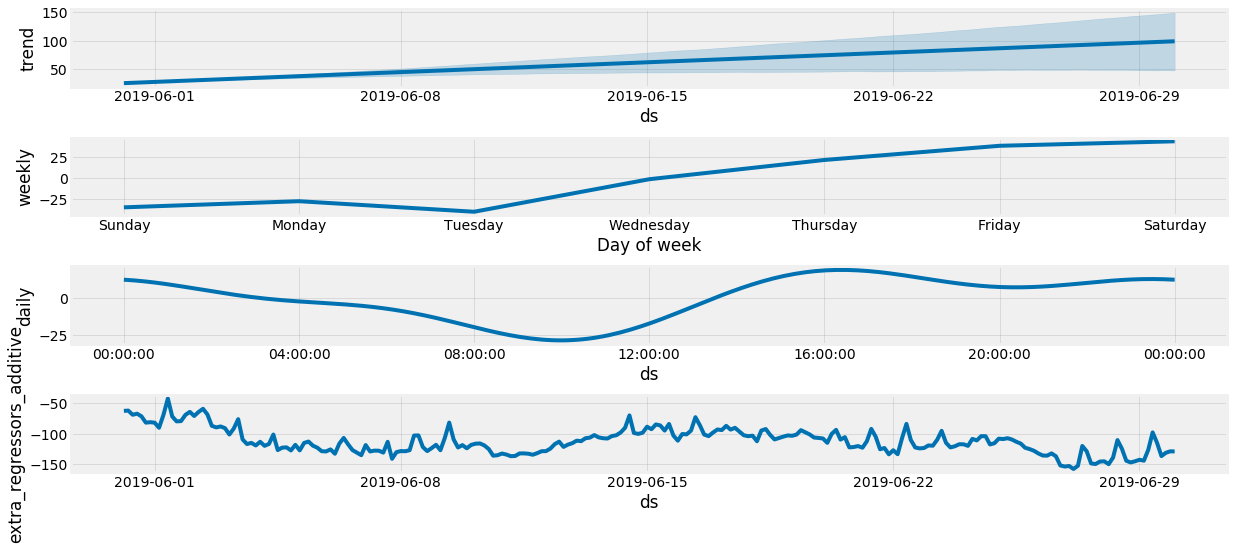

In [165]:
fig21 = pro_regressorSTP.plot(forecast_dataSTP);
fig22 = pro_regressorSTP.plot_components(forecast_dataSTP)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

In [166]:
forecast_dataSTP

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,STP_TSoil10_1_1_1,STP_TSoil10_1_1_1_lower,STP_TSoil10_1_1_1_upper,STP_TSoil20_1_1_1,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-05-31 03:00:00,25.311148,-177.445168,190.770968,25.311148,25.311148,-161.329072,-161.329072,-161.329072,-86.238379,...,-62.738294,-62.738294,-62.738294,44.527409,44.527409,44.527409,0.0,0.0,0.0,7.602186
1,2019-05-31 06:00:00,25.619982,-176.560909,195.722077,25.619982,25.619982,-155.789807,-155.789807,-155.789807,-88.688112,...,-62.315357,-62.315357,-62.315357,50.047861,50.047861,50.047861,0.0,0.0,0.0,6.323539
2,2019-05-31 09:00:00,25.928816,-182.342743,168.949912,25.928816,25.928816,-169.148057,-169.148057,-169.148057,-102.988331,...,-69.077772,-69.077772,-69.077772,54.445568,54.445568,54.445568,0.0,0.0,0.0,-14.458352
3,2019-05-31 12:00:00,26.237649,-195.609235,177.743395,26.237649,26.237649,-190.377549,-190.377549,-190.377549,-121.812592,...,-67.344162,-67.344162,-67.344162,57.124091,57.124091,57.124091,0.0,0.0,0.0,-0.981827
4,2019-05-31 15:00:00,26.546483,-161.333604,204.235634,26.538690,26.546483,-219.079823,-219.079823,-219.079823,-142.354699,...,-71.629165,-71.629165,-71.629165,57.606238,57.606238,57.606238,0.0,0.0,0.0,26.962313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2019-06-29 12:00:00,97.887092,-225.913137,156.876181,47.892225,146.981050,-365.243245,-365.243245,-365.243245,-259.486804,...,-114.766396,-114.766396,-114.766396,0.516119,0.516119,0.516119,0.0,0.0,0.0,-33.362590
236,2019-06-29 15:00:00,98.195926,-213.583118,137.864005,48.034145,147.607231,-417.800935,-417.800935,-417.800935,-278.185924,...,-136.380644,-136.380644,-136.380644,-10.709282,-10.709282,-10.709282,0.0,0.0,0.0,-34.455243
237,2019-06-29 18:00:00,98.504760,-226.647370,149.046466,48.003107,148.233897,-415.704115,-415.704115,-415.704115,-258.955902,...,-130.988161,-130.988161,-130.988161,-20.681552,-20.681552,-20.681552,0.0,0.0,0.0,-38.611626
238,2019-06-29 21:00:00,98.813594,-232.240404,129.059841,47.848336,148.843186,-391.143225,-391.143225,-391.143225,-230.006586,...,-128.615935,-128.615935,-128.615935,-28.867566,-28.867566,-28.867566,0.0,0.0,0.0,-50.807462


### Measure the performance of the model

In [167]:
mape = mean_absolute_percentage_error(mergeddf_test_gasSTP['y'],forecast_dataSTP['yhat'])
print("MAPE",round(mape,4))

MAPE 287.6752


### Compare the gas flux in test set and in forecasted set

In [168]:
pd.plotting.register_matplotlib_converters()

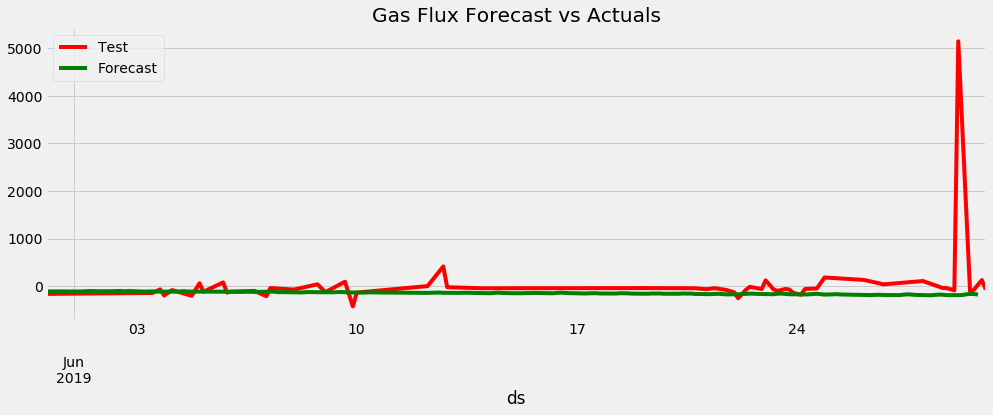

In [169]:
df2=mergeddf_test_gasSTP

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df2.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
forecast_data2.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Read the met data (Soil Parameters TDT) - the regressors to be added

In [170]:
metData_SoilTDTParams = read_excel('../plotData/MetData_SoilParams_TDT_Filtered.xlsx', sheet_name='Sheet1') 

metData_SoilTDTParams['ds'] = metData_SoilTDTParams['TIMESTAMP_1_rounded']

metData_SoilTDTParams.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
metData_SoilTDTParams.drop('TIMESTAMP_1_rounded', axis=1, inplace=True)
#metData_SoilTDTParams

### Round the met data to the nearest hour to get matching timestamps with gas flux data

In [171]:
plot_dataframe3 = metData_SoilTDTParams.copy()

plot_dataframe3['ds'] = metData_SoilTDTParams.index

#round the timestamp value to nearest half hour
plot_dataframe3['ds'] = plot_dataframe3['ds'].dt.round('1H')

#Create new index
plot_dataframe3.reset_index(drop=True, inplace=True)
plot_dataframe3.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)

plot_dataframe3

,TDT1_Ts_1_1_1,TDT2_Ts_1_1_1,TDT3_Ts_1_1_1,TDT4_Ts_1_1_1
ds,,,,
2019-03-26 18:00:00,8.50,10.15,12.05,13.60
2019-03-26 18:00:00,8.50,10.25,11.80,12.55
2019-03-26 18:00:00,8.55,10.30,11.40,11.50
2019-03-26 19:00:00,8.65,10.30,10.95,10.70
2019-03-26 20:00:00,8.70,10.25,10.55,10.20
...,...,...,...,...
2019-06-30 00:00:00,16.75,19.35,19.95,19.45
2019-06-30 00:00:00,16.80,19.25,19.65,19.10
2019-06-30 01:00:00,16.80,19.15,19.40,18.75


### Resampling every 3 hour

In [172]:
resample3        = plot_dataframe3.resample('3H') 
daily_mean_flux3 = resample3.mean()

#print(daily_mean_flux3)

### Merge the metdata together with the (gas flux) plot data

In [173]:
metData_SoilTDTParams = daily_mean_flux3

metData_SoilTDTParams.to_csv('metdata-soilSTPparams.csv')
#metData_SoilTDTParams

In [174]:
dfTDT = data.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
dfTDT.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
dfTDT.drop('index', axis=1, inplace=True)
#dfTDT

### Add Regressors to the model

In [175]:
merged_df_TDT = dfTDT.merge(metData_SoilTDTParams, left_index=True, right_index=True, how='inner')

#merged_df_TDT

### Interpolate to replace missing values

In [176]:
merged_df_TDT = merged_df_TDT.interpolate(method='linear')
merged_df_TDT

,y,TDT1_Ts_1_1_1,TDT2_Ts_1_1_1,TDT3_Ts_1_1_1,TDT4_Ts_1_1_1
ds,,,,,
2019-03-26 18:00:00,-61.782600,8.621429,10.207143,10.992857,11.150000
2019-03-26 21:00:00,-25.552200,8.870000,9.720000,9.180000,8.470000
2019-03-27 00:00:00,-35.076767,8.914286,9.028571,7.807143,6.664286
2019-03-27 03:00:00,-44.601333,8.890000,8.260000,6.760000,6.040000
2019-03-27 06:00:00,-54.125900,8.742857,7.835714,6.764286,6.507143
...,...,...,...,...,...
2019-06-29 12:00:00,-114.951200,15.700000,17.564286,20.757143,24.321429
2019-06-29 15:00:00,-74.633900,15.830000,19.240000,23.440000,26.520000
2019-06-29 18:00:00,26.288600,16.200000,20.064286,22.878571,23.407143


#### Split the merged dataset into training and test set on Resampled Dataset

In [177]:
#Train Test - split data
split_date = '31-May-2019'  

mergeddf_train_gasTDT = merged_df_TDT.loc[merged_df_TDT.index <= split_date].copy()
mergeddf_test_gasTDT  = merged_df_TDT.loc[merged_df_TDT.index > split_date].copy()

mergeddf_train_gasTDT.reset_index(inplace=True)
mergeddf_test_gasTDT.reset_index(inplace=True)

In [178]:
#mergeddf_train_gasTDT

### Create Prophet model

In [179]:
pro_regressorTDT = Prophet()  #add tuning parameters later
pro_regressorTDT.add_regressor('TDT1_Ts_1_1_1')
pro_regressorTDT.add_regressor('TDT2_Ts_1_1_1')
pro_regressorTDT.add_regressor('TDT3_Ts_1_1_1')
pro_regressorTDT.add_regressor('TDT4_Ts_1_1_1')

#Fitting the data
pro_regressorTDT.fit(mergeddf_train_gasTDT)

#forecast the data for Test  data
forecast_dataTDT = pro_regressorTDT.predict(mergeddf_test_gasTDT)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


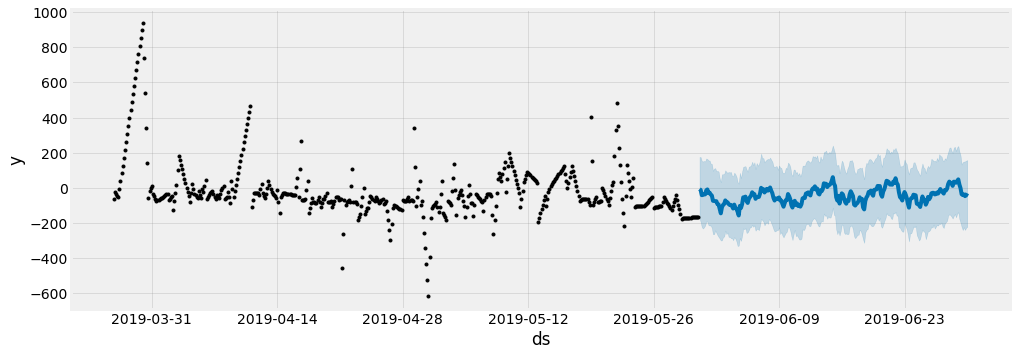

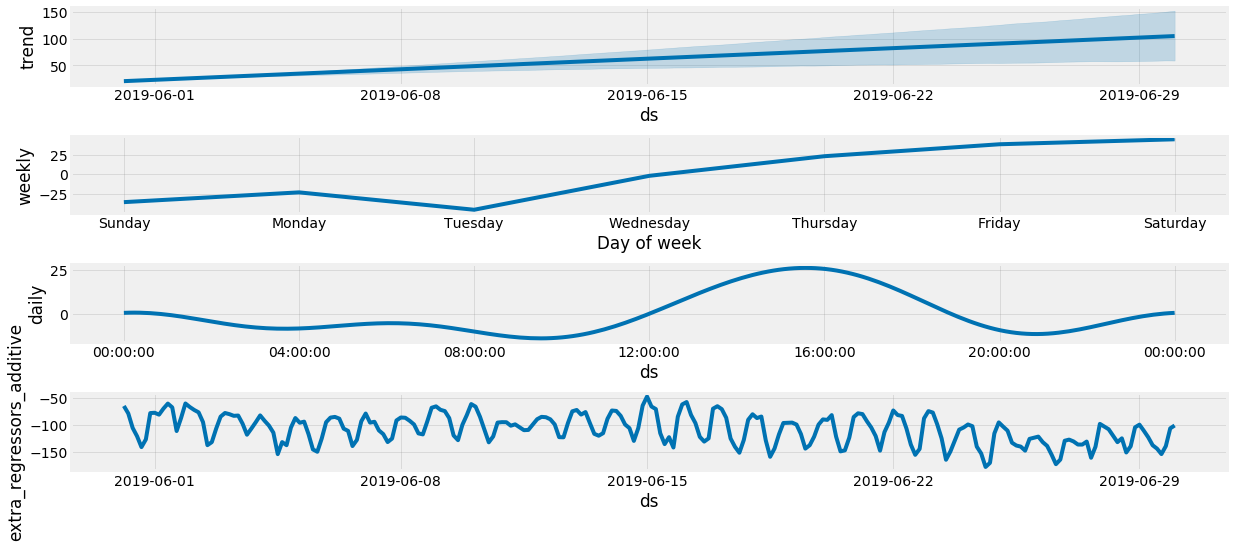

In [180]:
fig21 = pro_regressorTDT.plot(forecast_dataTDT);
fig22 = pro_regressorTDT.plot_components(forecast_dataTDT)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

### Measure the performance of the model

In [181]:
mape = mean_absolute_percentage_error(mergeddf_test_gasTDT['y'],forecast_dataTDT['yhat'])
print("MAPE",round(mape,4))

MAPE 224.4159


### Compare the gas flux in test set and in forecasted set

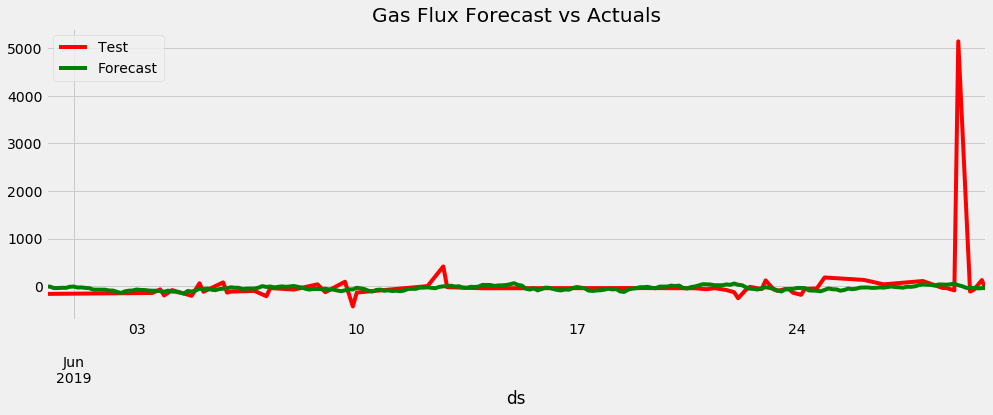

In [182]:
df2=mergeddf_test_gasTDT

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df2.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
forecast_dataTDT.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Read the met data (Volumetric Water Content Parameters) - the regressors to be added

In [183]:
metData_VWCParams = read_excel('../plotData/MetData_VolumetricWaterContent_VWC_Filtered.xlsx', sheet_name='Sheet1') 

metData_VWCParams['ds'] = metData_VWCParams['TIMESTAMP_1_rounded']

metData_VWCParams.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
metData_VWCParams.drop('TIMESTAMP_1_rounded', axis=1, inplace=True)
#metData_VWCParams

### Round the met data to the nearest hour to get matching timestamps with gas flux data

In [184]:
plot_dataframe3 = metData_VWCParams.copy()
plot_dataframe3['ds'] = metData_VWCParams.index

#round the timestamp value to nearest half hour
plot_dataframe3['ds'] = plot_dataframe3['ds'].dt.round('1H')

#Create new index
plot_dataframe3.reset_index(drop=True, inplace=True)
plot_dataframe3.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)

#plot_dataframe3

### Resampling every 3 hour

In [185]:
resample3        = plot_dataframe3.resample('3H') 
daily_mean_flux3 = resample3.mean()
#print(daily_mean_flux3)

### Merge the Volumetric Water Content together with the (gas flux) plot data

In [186]:
metData_VWCParams = daily_mean_flux3

In [187]:
metData_VWCParams.to_csv('metdata-vwcparams1.csv')
#metData_VWCParams

In [188]:
dfV = data.reset_index().rename(columns={'DateTime': 'ds', 'Flux': 'y'})
dfV.set_index('ds', drop=True, append=False, inplace=True, verify_integrity=False)
dfV.drop('index', axis=1, inplace=True)
#dfV

### Add Regressors to the model

In [189]:
merged_df_Vwc = dfV.merge(metData_VWCParams, left_index=True, right_index=True, how='inner')

#merged_df_Vwc

### Interpolate to replace missing values

In [190]:
merged_df_Vwc = merged_df_Vwc.interpolate(method='linear')
#merged_df_TDT

#### Split the merged dataset into training and test set on Resampled Dataset

In [191]:
#Train Test - split data
split_date = '31-May-2019'   #'30-April-2019'

#dataf = daily_mean_flux

mergeddf_train_gasVwc = merged_df_Vwc.loc[merged_df_Vwc.index <= split_date].copy()
mergeddf_test_gasVwc  = merged_df_Vwc.loc[merged_df_Vwc.index > split_date].copy()

mergeddf_train_gasVwc.reset_index(inplace=True)
mergeddf_test_gasVwc.reset_index(inplace=True)

mergeddf_train_gasVwc.dropna(inplace=True)
mergeddf_test_gasVwc.dropna(inplace=True)

In [192]:
#mergeddf_test_gasVwc

In [193]:
merged_df_Vwc.to_excel('ch4_vwcparams_3h.xlsx')

### Create Prophet model

In [194]:
pro_regressorV = Prophet()  #add tuning parameters later
pro_regressorV.add_regressor('VWC_1_1_1')
pro_regressorV.add_regressor('VWC_2_1_1')
pro_regressorV.add_regressor('VWC_3_1_1')
pro_regressorV.add_regressor('VWC_4_1_1')

#Fitting the data
pro_regressorV.fit(mergeddf_train_gasVwc)

#future_data = pro_regressor.make_future_dataframe(periods=14, freq='D')

#forecast the data for Test  data
forecast_dataV = pro_regressorV.predict(mergeddf_test_gasVwc)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


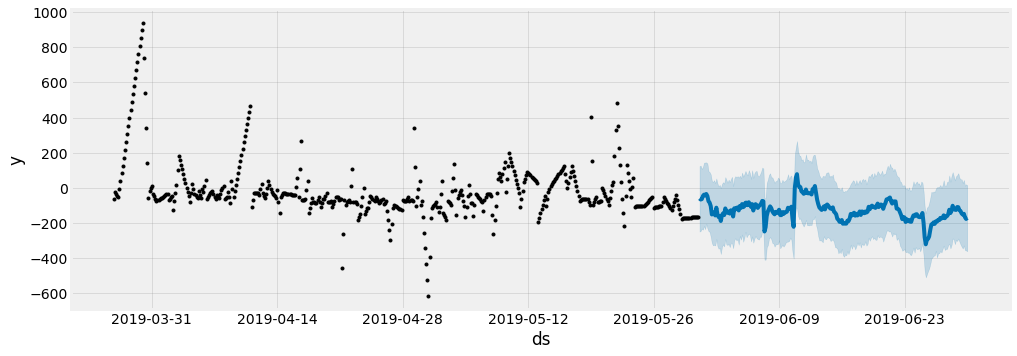

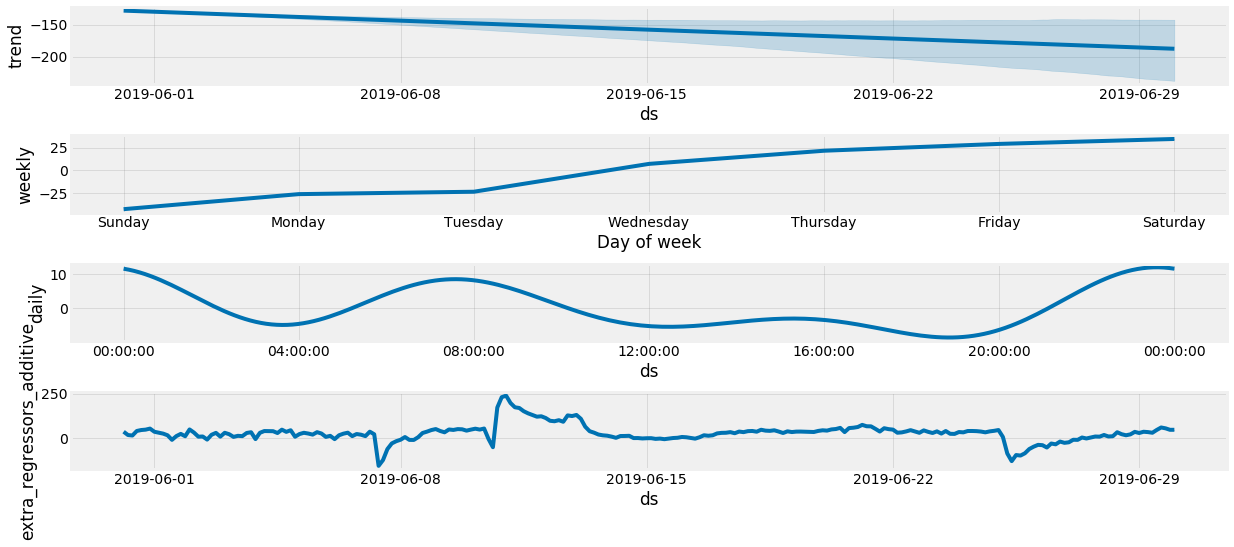

In [195]:
fig21 = pro_regressorV.plot(forecast_dataV);
fig22 = pro_regressorV.plot_components(forecast_dataV)

fig21.set_figheight(5)
fig21.set_figwidth(15)

fig22.set_figheight(7)
fig22.set_figwidth(19)

### Measure the performance of the model

In [196]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [197]:
mape = mean_absolute_percentage_error(mergeddf_test_gasVwc['y'],forecast_dataV['yhat'])
print("MAPE",round(mape,4))

MAPE 374.5189


### Compare the gas flux in test set and in forecasted set

In [198]:
pd.plotting.register_matplotlib_converters()

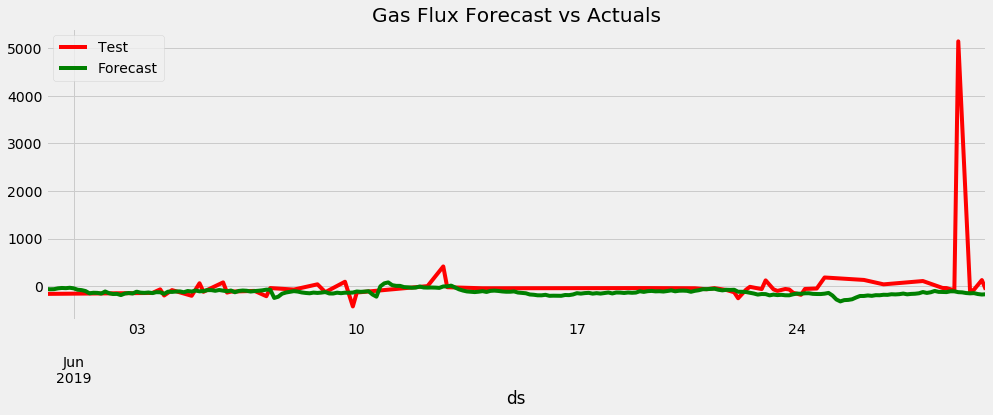

In [199]:
#pd.plotting.register_matplotlib_converters()

df4 = mergeddf_test_gasVwc

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df4.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
forecast_dataV.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

plt.title('Gas Flux Forecast vs Actuals')
plt.show() 

### Hide code for printing/visualising purposes

In [200]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')